In [93]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
folder = "signal_evolution_data/"  # Set your folder path
metadata = pd.read_pickle(folder + 'metadata.pkl')
noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')


# Gather all the unique topic IDs and their representations from all dataframes at all timestamps
topic_representations = {}

# Assuming representation column name is 'Representation' in all dfs
for df_list in [noise_df_list, ws_df_list, ss_df_list]:
    for df in df_list:
        if not df.empty:
            for index, row in df.iterrows():
                topic_number = row['Topic']
                # Ensure topic_number is converted to string
                topic_number_str = str(topic_number)
                # Extract first three words from the representation
                first_three_words = '_'.join(row['Representation'].split('_')[:3])
                topic_representations[topic_number_str] = f"{topic_number_str}_{first_three_words}"

# Sort topics by their number
sorted_topic_representations = dict(sorted(topic_representations.items(), key=lambda item: int(item[0])))

# Select the first N topics
selected_topic_representations = dict(list(sorted_topic_representations.items()))

# Create a dataframe to store the signal strength for each topic at each timestamp
heatmap_data = []

# Iterate over the timestamps
for t in range(len(metadata['timestamps'])):
    ts = pd.to_datetime(metadata['timestamps'][t]).strftime('%Y-%m-%d')  # Format timestamp to 'YYYY MM DD'
    
    # Initialize the signal strength for each topic at the current timestamp
    signal_strength = {label: 0 for label in selected_topic_representations.values()}
    
    # Update the signal strength based on the presence of topics in each dataframe
    for topic, label in selected_topic_representations.items():
        if not noise_df_list[t].empty and int(topic) in noise_df_list[t]['Topic'].tolist():
            signal_strength[label] = 1
        elif not ws_df_list[t].empty and int(topic) in ws_df_list[t]['Topic'].tolist():
            signal_strength[label] = 2
        elif not ss_df_list[t].empty and int(topic) in ss_df_list[t]['Topic'].tolist():
            signal_strength[label] = 3
    
    # Append the signal strength for each topic at the current timestamp to the heatmap data
    heatmap_data.append({
        'Timestamp': ts,
        **signal_strength
    })

# Create a dataframe from the heatmap data
heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df.reset_index(drop=True).set_index('Timestamp', inplace=True)

# Sort the heatmap dataframe by topic number
heatmap_df = heatmap_df[selected_topic_representations.values()]



In [1]:
import os
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
import re

# Load the data
folder = "signal_evolution_data/"
metadata = pd.read_pickle(folder + 'metadata.pkl')
noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')

# Function to get the color based on the topic's category
def get_color(topic, noise_df, ws_df, ss_df):
    if not noise_df.empty and topic in noise_df['Topic'].values:
        return 'gray'
    elif not ws_df.empty and topic in ws_df['Topic'].values:
        return 'blue'
    elif not ss_df.empty and topic in ss_df['Topic'].values:
        return 'red'
    else:
        return None

# Function to get the popularity and representation of a topic
def get_popularity_and_representation(topic, noise_df, ws_df, ss_df):
    if not noise_df.empty and topic in noise_df['Topic'].values:
        return noise_df[noise_df['Topic'] == topic][['Latest Popularity', 'Representation']].values[0]
    elif not ws_df.empty and topic in ws_df['Topic'].values:
        return ws_df[ws_df['Topic'] == topic][['Latest Popularity', 'Representation']].values[0]
    elif not ss_df.empty and topic in ss_df['Topic'].values:
        return ss_df[ss_df['Topic'] == topic][['Latest Popularity', 'Representation']].values[0]
    else:
        return None, None

# Specify the list of topics you want to visualize
topics_to_visualize = [2462, 2139]  # Replace with the topic numbers you want to visualize

# Create the line plot using Plotly
fig = go.Figure()

# Initialize a dictionary to store the representations for each timestamp
timestamp_representations = {}

for topic in topics_to_visualize:
    # Initialize lists to store data for the topic
    timestamps = []
    popularities = []
    colors = []
    representations = []

    # Iterate over the timestamps
    for i in range(len(metadata['timestamps'])):
        noise_df = noise_df_list[i]
        ws_df = ws_df_list[i]
        ss_df = ss_df_list[i]
        
        color = get_color(topic, noise_df, ws_df, ss_df)
        popularity, representation = get_popularity_and_representation(topic, noise_df, ws_df, ss_df)
        
        if color is not None and popularity is not None:
            timestamps.append(metadata['timestamps'][i])
            popularities.append(popularity)
            colors.append(color)
            representations.append(representation)
            
            # Store the representation for this timestamp and topic
            if metadata['timestamps'][i] not in timestamp_representations:
                timestamp_representations[metadata['timestamps'][i]] = {}
            timestamp_representations[metadata['timestamps'][i]][topic] = representation

    # Create the line segments with the corresponding colors
    line_segments = []
    for i in range(len(timestamps) - 1):
        line_segments.append(go.Scatter(
            x=[timestamps[i], timestamps[i+1]],
            y=[popularities[i], popularities[i+1]],
            mode='lines',
            line=dict(color=colors[i]),
            showlegend=False,
            hoverinfo='none'
        ))

    # Add the line segments to the figure
    for segment in line_segments:
        fig.add_trace(segment)

    # Add the markers with hover information
    fig.add_trace(go.Scatter(
        x=timestamps,
        y=popularities,
        mode='markers',
        marker=dict(color=colors),
        hoverinfo='none',
        name=f'Topic {topic}'
    ))

# Add the threshold plots
fig.add_trace(go.Scatter(
    x=metadata['timestamps'],
    y=metadata['q1_values'],
    mode='lines',
    line=dict(color='purple', dash='dash'),
    name='Q1 Threshold',
    hoverinfo='none'
))

fig.add_trace(go.Scatter(
    x=metadata['timestamps'],
    y=metadata['q3_values'],
    mode='lines',
    line=dict(color='orange', dash='dash'),
    name='Q3 Threshold',
    hoverinfo='none'
))

# Create the hover text for each timestamp
hover_data = []
for timestamp in metadata['timestamps']:
    if timestamp in timestamp_representations:
        topic_reprs = []
        for topic, representation in timestamp_representations[timestamp].items():
            topic_repr = f"Topic {topic}: {' - '.join(representation.split('_')[:5])}"
            topic_reprs.append(topic_repr)
        hover_text = '<br>'.join(topic_reprs)
    else:
        hover_text = 'No representation available'
    hover_data.append(hover_text)

# Add an invisible scatter trace for the hover data
fig.add_trace(go.Scatter(
    x=metadata['timestamps'],
    y=[0] * len(metadata['timestamps']),
    mode='markers',
    hovertext=hover_data,
    hoverinfo='text',
    showlegend=False,
    marker=dict(color='rgba(0, 0, 0, 0)', size=10)
))

# Update the layout
fig.update_layout(
    title='Popularity of Topics Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Popularity',

    hoverlabel=dict(
        font=dict(size=16)
    ),
    hovermode='x'
)

# Add custom legend
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(color='gray', size=10),
    name='Noise',
    legendgroup='category',
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(color='blue', size=10),
    name='Weak Signal',
    legendgroup='category',
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Strong Signal',
    legendgroup='category',
    showlegend=True
))

fig.update_layout(
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()

In [13]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re

sns.set_theme(style="darkgrid")

def load_data(folder):
    metadata = pd.read_pickle(folder + 'metadata.pkl')
    noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
    ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
    ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')
    return metadata, noise_df_list, ws_df_list, ss_df_list

def get_topic_category(topic, noise_df, ws_df, ss_df):
    if not noise_df.empty and topic in noise_df['Topic'].values:
        return 'Noise'
    elif not ws_df.empty and topic in ws_df['Topic'].values:
        return 'Weak Signal'
    elif not ss_df.empty and topic in ss_df['Topic'].values:
        return 'Strong Signal'
    else:
        return None

def get_topic_data(topic, noise_df, ws_df, ss_df):
    dfs = [df for df in [noise_df, ws_df, ss_df] if not df.empty and topic in df['Topic'].values]
    if dfs:
        return dfs[0][dfs[0]['Topic'] == topic][['Latest_Popularity', 'Representation']].values[0]
    return None, None

def extract_representation(representation):
    words = representation.split('_')
    return ' - '.join(words[:4])

def prepare_data(metadata, noise_df_list, ws_df_list, ss_df_list, topics_to_visualize, label_index):
    topic_representations = {topic: [] for topic in topics_to_visualize}
    data = []
    
    # Collect all representations for each topic
    for i in range(len(metadata['timestamps'])):
        timestamp = metadata['timestamps'][i]
        noise_df, ws_df, ss_df = noise_df_list[i], ws_df_list[i], ss_df_list[i]
        for topic in topics_to_visualize:
            category = get_topic_category(topic, noise_df, ws_df, ss_df)
            popularity, representation = get_topic_data(topic, noise_df, ws_df, ss_df)
            if category and popularity:
                topic_representations[topic].append(representation)


    
    # Build the final data using the specified label_index
    for topic in topics_to_visualize:
        for i in range(len(metadata['timestamps'])):
            timestamp = metadata['timestamps'][i]
            noise_df, ws_df, ss_df = noise_df_list[i], ws_df_list[i], ss_df_list[i]
            category = get_topic_category(topic, noise_df, ws_df, ss_df)
            popularity, representation = get_topic_data(topic, noise_df, ws_df, ss_df)
            if category and popularity:
                if len(topic_representations[topic]) > label_index:
                    selected_representation = topic_representations[topic][label_index]
                    representation_label = extract_representation(selected_representation) if selected_representation else None
                else:
                    representation_label = None
                data.append({'Timestamp': timestamp, 'Topic': topic, 'Popularity': popularity,
                             'Category': category, 'Representation': representation_label})
            else:
                data.append({'Timestamp': timestamp, 'Topic': topic, 'Popularity': None,
                             'Category': None, 'Representation': None})
    
    return pd.DataFrame(data)


from matplotlib.patches import Patch

def plot_topic_popularity(df, metadata, start_date, end_date, topics_to_visualize, arrow_topic, arrow_scatter_index, save_to_pdf=False, save_folder=''):
    plt.figure(figsize=(14, 8))
    
    # Adjusting font sizes and making text bold
    plt.rc('font', size=20,)  # General font size and weight
    plt.rc('axes', titlesize=24,)  # Axes title size and weight
    plt.rc('axes', labelsize=20,)  # X and Y labels size and weight
    plt.rc('xtick', labelsize=14)  # X tick labels size and weight
    plt.rc('ytick', labelsize=14,)  # Y tick labels size and weight

    # Create the plot
    ax = plt.gca()
    
    arrow_x = None
    arrow_y = None

    for topic in topics_to_visualize:
        topic_df = df[df['Topic'] == topic]
        topic_df = topic_df.dropna(subset=['Popularity'])
        topic_df = topic_df.sort_values('Timestamp')
        label = topic_df['Representation'].iloc[0] if not topic_df['Representation'].isnull().all() else topic
        sns.lineplot(data=topic_df, x='Timestamp', y='Popularity', label=label, marker='o', markersize=20, linewidth=6, ax=ax)
        if topic == arrow_topic:
            topic_timestamps = topic_df['Timestamp'].tolist()
            if arrow_scatter_index < len(topic_timestamps):
                arrow_x = topic_timestamps[arrow_scatter_index]
                arrow_y = topic_df[topic_df['Timestamp'] == arrow_x]['Popularity'].values[0]
                ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y * 1.2),
                            arrowprops=dict(facecolor='red', edgecolor='black', width=5, headwidth=25, headlength=25))

                for topic_data in df[df['Timestamp'] == arrow_x].itertuples():
                    if not pd.isnull(topic_data.Popularity):
                        ax.annotate(f'{topic_data.Popularity:.2f}', (arrow_x, topic_data.Popularity),
                                    textcoords="offset points", xytext=(-30, -5), ha='center', fontsize=14,
                                    color='black', bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # Fill the areas with different colors
    ax.fill_between(metadata['timestamps'], metadata['q3_values'], 10**5, color='green', alpha=0.3)
    ax.fill_between(metadata['timestamps'], metadata['q1_values'], metadata['q3_values'], color='red', alpha=0.3)
    ax.fill_between(metadata['timestamps'], 0, metadata['q1_values'], color='grey', alpha=0.3)
    
    # Plot the thresholds without adding them to the legend
    ax.plot(metadata['timestamps'], metadata['q1_values'], linestyle='--', color='red', label='_nolegend_', linewidth=2)
    ax.plot(metadata['timestamps'], metadata['q3_values'], linestyle='--', color='green', label='_nolegend_', linewidth=2)
    
    if arrow_x is not None:
        # Retrieve the index of the arrow timestamp
        arrow_index = metadata['timestamps'].index(arrow_x)
        q1_value = metadata['q1_values'][arrow_index]
        q3_value = metadata['q3_values'][arrow_index]
        
        # Add the lower and upper threshold values at the top left
        ax.text(0.02, 0.95, f'Lower threshold: {q1_value:.2f}\nUpper threshold: {q3_value:.2f}', transform=ax.transAxes,
                fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5), weight='bold')

        # Enhance the title with the timestamp of the red arrow
        plt.title(f'NYT News (2020) | {start_date.strftime("%m-%d")} to {end_date.strftime("%m-%d")} | Arrow Timestamp: {arrow_x.strftime("%Y-%m-%d")}', fontsize=24, weight='bold')
    else:
        plt.title(f'NYT News (2020) | {start_date.strftime("%m-%d")} to {end_date.strftime("%m-%d")}', fontsize=24, weight='bold')
    
    # Set plot properties
    plt.yscale('log')
    plt.xlabel('Timestamp', fontweight="bold")
    plt.ylabel('Popularity (Log Scale)', fontweight="bold")
    plt.xlim(start_date, end_date)
    plt.ylim(10**-4, 10**3)
    
    # Main legend for topics
    topic_legend = plt.legend(title='Topics', loc='lower right', prop={'size': 18, 'weight': 'bold'})  # Adjust legend text size and make it bold
    plt.gca().add_artist(topic_legend)
    
    # Custom legend for signals
    handles = [
        Patch(color='green', alpha=0.3, label='Strong Signals'),
        Patch(color='red', alpha=0.3, label='Weak Signals'),
        Patch(color='grey', alpha=0.3, label='Noise')
    ]
    plt.legend(handles=handles, loc='upper right', title='Signal Strength', prop={'size': 18, 'weight': 'bold'})  # Adjust size and weight here

    plt.tight_layout()
    
    if save_to_pdf:
        if not save_folder.endswith('/'):
            save_folder += '/'
        plt.savefig(f'{save_folder}topic_popularity_{start_date.strftime("%Y-%m-%d")}_to_{end_date.strftime("%Y-%m-%d")}.pdf')
    
    plt.show()


In [14]:
# Usage example
folder = "signal_evolution_data_nyt/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)
print(len(metadata['timestamps']), metadata['timestamps'][0], metadata['timestamps'][-1])

725 2019-01-13 00:00:00 2022-12-31 00:00:00


In [15]:
def get_timestamp_index(date_str, timestamps):
    date = pd.Timestamp(date_str)
    for i, ts in enumerate(timestamps):
        if ts.date() == date.date():
            return i
    return -1

# Example usage
date_str = '2020-01-18'
index = get_timestamp_index(date_str, metadata['timestamps'])
print(f"The index of the date {date_str} is {index}")

The index of the date 2020-01-18 is 185


In [16]:
# NYT
noise_signals = [3371]
weak_signals = [3724]
strong_signals = [3585, 3687]
topics_to_visualize = weak_signals + strong_signals + noise_signals

label_index = 1
start_date = datetime(2020, 1, 15)
end_date = datetime(2020, 2, 15)

arrow_topic = 3724
arrow_scatter_index = 0

save_to_pdf=False
save_folder='Figures'

df = prepare_data(metadata, noise_df_list, ws_df_list, ss_df_list, topics_to_visualize, label_index)
plot_topic_popularity(df, metadata, start_date, end_date, topics_to_visualize, arrow_topic, arrow_scatter_index, save_to_pdf, save_folder)

KeyError: 'Unrecognized key "xtick.weight" for group "xtick" and name "weight"'

<Figure size 1400x800 with 0 Axes>

# ARXIV

In [56]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re

sns.set_theme(style="darkgrid")

def load_data(folder):
    metadata = pd.read_pickle(folder + 'metadata.pkl')
    noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
    ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
    ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')
    return metadata, noise_df_list, ws_df_list, ss_df_list

def get_topic_category(topic, noise_df, ws_df, ss_df):
    if not noise_df.empty and topic in noise_df['Topic'].values:
        return 'Noise'
    elif not ws_df.empty and topic in ws_df['Topic'].values:
        return 'Weak Signal'
    elif not ss_df.empty and topic in ss_df['Topic'].values:
        return 'Strong Signal'
    else:
        return None

def get_topic_data(topic, noise_df, ws_df, ss_df):
    dfs = [df for df in [noise_df, ws_df, ss_df] if not df.empty and topic in df['Topic'].values]
    if dfs:
        return dfs[0][dfs[0]['Topic'] == topic][['Latest_Popularity', 'Representation']].values[0]
    return None, None

def extract_representation(representation):
    words = representation.split('_')
    return ' - '.join(words[:4])

def prepare_data(metadata, noise_df_list, ws_df_list, ss_df_list, topics_to_visualize, label_indices):
    topic_representations = {topic: [] for topic in topics_to_visualize}
    data = []

    # Collect all representations for each topic
    for i in range(len(metadata['timestamps'])):
        timestamp = metadata['timestamps'][i]
        noise_df, ws_df, ss_df = noise_df_list[i], ws_df_list[i], ss_df_list[i]
        for topic in topics_to_visualize:
            category = get_topic_category(topic, noise_df, ws_df, ss_df)
            popularity, representation = get_topic_data(topic, noise_df, ws_df, ss_df)
            if category and popularity:
                topic_representations[topic].append(representation)

    # Build the final data using the specified label_index for each topic
    for topic in topics_to_visualize:
        for i in range(len(metadata['timestamps'])):
            timestamp = metadata['timestamps'][i]
            noise_df, ws_df, ss_df = noise_df_list[i], ws_df_list[i], ss_df_list[i]
            category = get_topic_category(topic, noise_df, ws_df, ss_df)
            popularity, representation = get_topic_data(topic, noise_df, ws_df, ss_df)
            if category and popularity:
                label_index = label_indices.get(topic, -1)  # Default to the last available representation if not specified
                if len(topic_representations[topic]) > label_index:
                    selected_representation = topic_representations[topic][label_index]
                    representation_label = extract_representation(selected_representation) if selected_representation else None
                else:
                    selected_representation = topic_representations[topic][-1]
                    representation_label = extract_representation(selected_representation)
                data.append({'Timestamp': timestamp, 'Topic': topic, 'Popularity': popularity,
                             'Category': category, 'Representation': representation_label})
            else:
                data.append({'Timestamp': timestamp, 'Topic': topic, 'Popularity': None,
                             'Category': None, 'Representation': None})

    return pd.DataFrame(data)

from matplotlib.patches import Patch

def plot_topic_popularity(df, metadata, start_date, end_date, topics_to_visualize, arrow_topic, arrow_scatter_index, save_to_pdf=False, save_folder=''):
    plt.figure(figsize=(14, 8))
    
    # Adjusting font sizes
    plt.rc('font', size=20)  # General font size
    plt.rc('axes', titlesize=20)  # Axes title
    plt.rc('axes', labelsize=20)  # X and Y labels
    plt.rc('xtick', labelsize=14)  # X tick labels
    plt.rc('ytick', labelsize=14)  # Y tick labels

    # Create the plot
    ax = plt.gca()
    
    arrow_x = None
    arrow_y = None

    for topic in topics_to_visualize:
        topic_df = df[df['Topic'] == topic]
        topic_df = topic_df.dropna(subset=['Popularity'])
        topic_df = topic_df.sort_values('Timestamp')
        label = topic_df['Representation'].iloc[0] if not topic_df['Representation'].isnull().all() else topic
        sns.lineplot(data=topic_df, x='Timestamp', y='Popularity', label=label, marker='o', markersize=1, linewidth=6, ax=ax)
        if topic == arrow_topic:
            topic_timestamps = topic_df['Timestamp'].tolist()
            if arrow_scatter_index < len(topic_timestamps):
                arrow_x = topic_timestamps[arrow_scatter_index]
                arrow_y = topic_df[topic_df['Timestamp'] == arrow_x]['Popularity'].values[0]
                ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y * 1.2),
                            arrowprops=dict(facecolor='red', edgecolor='black', width=5, headwidth=25, headlength=25))

                for topic_data in df[df['Timestamp'] == arrow_x].itertuples():
                    if not pd.isnull(topic_data.Popularity):
                        ax.annotate(f'{topic_data.Popularity:.2f}', (arrow_x, topic_data.Popularity),
                                    textcoords="offset points", xytext=(30, -5), ha='center', fontsize=14,
                                    color='black', bbox=dict(facecolor='white', edgecolor='none', pad=2))

    # Fill the areas with different colors
    ax.fill_between(metadata['timestamps'], metadata['q3_values'], 10**5, color='green', alpha=0.3)
    ax.fill_between(metadata['timestamps'], metadata['q1_values'], metadata['q3_values'], color='red', alpha=0.3)
    ax.fill_between(metadata['timestamps'], 0, metadata['q1_values'], color='grey', alpha=0.3)
    
    # Plot the thresholds without adding them to the legend
    ax.plot(metadata['timestamps'], metadata['q1_values'], linestyle='--', color='red', label='_nolegend_', linewidth=2)
    ax.plot(metadata['timestamps'], metadata['q3_values'], linestyle='--', color='green', label='_nolegend_', linewidth=2)
    
    if arrow_x is not None:
        # Retrieve the index of the arrow timestamp
        arrow_index = metadata['timestamps'].index(arrow_x)
        q1_value = metadata['q1_values'][arrow_index]
        q3_value = metadata['q3_values'][arrow_index]
        
        # Add the lower and upper threshold values at the top left
        ax.text(0.02, 0.95, f'Lower threshold: {q1_value:.2f}\nUpper threshold: {q3_value:.2f}', transform=ax.transAxes,
                fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        # Enhance the title with the timestamp of the red arrow
        plt.title(f'ArXiv cs.* papers | {start_date.strftime("%Y-%m")} to {end_date.strftime("%Y-%m")} | Arrow Timestamp: {arrow_x.strftime("%Y-%m-%d")}')
    else:
        plt.title(f'ArXiv cs.* papers | {start_date.strftime("%Y-%m")} to {end_date.strftime("%Y-%m")}')
    
    # Set plot properties
    plt.yscale('log')
    plt.xlabel('Timestamp', fontweight="bold")
    plt.ylabel('Popularity (Log Scale)', fontweight="bold")
    plt.xlim(start_date, end_date)
    plt.ylim(10**-2, 10**3)
    
    # Main legend for topics
    topic_legend = plt.legend(title='Topics', loc='lower right', prop={'size': 18, 'weight': 'bold'})  # Adjust legend text size and make it bold
    plt.gca().add_artist(topic_legend)
    
    plt.tight_layout()
    
    if save_to_pdf:
        if not save_folder.endswith('/'):
            save_folder += '/'
        plt.savefig(f'{save_folder}topic_popularity_{start_date.strftime("%Y-%m-%d")}_to_{end_date.strftime("%Y-%m-%d")}.pdf')
    
    plt.show()





In [44]:
# Usage example
folder = "signal_evolution_data_arxiv/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)
print(len(metadata['timestamps']), metadata['timestamps'][0], metadata['timestamps'][-1])

360 2017-02-01 00:00:00 2023-12-20 00:00:00


In [45]:
def get_timestamp_index(date_str, timestamps):
    date = pd.Timestamp(date_str)
    for i, ts in enumerate(timestamps):
        if ts.date() == date.date():
            return i
    return -1

# Example usage
date_str = '2020-06-10'
index = get_timestamp_index(date_str, metadata['timestamps'])
print(f"The index of the date {date_str} is {index}")

The index of the date 2020-06-10 is 175


In [46]:
ws_df_list[175]

,Topic,Representation,Latest_Popularity,Docs_Count,Paragraphs_Count,Latest_Timestamp,Documents,Sources,Source_Diversity
0,5,smart homes_amazon alexa_home iot_alexa_alexa ...,5.466758,129,129,2020-06-10,[],{None},1
1,7,retweet cascades_twitter_presence twitter_onli...,3.096330,242,242,2020-06-10,[],{None},1
2,14,graph clustering_graph metric_local graph_metr...,5.000000,83,83,2020-06-10,[],{None},1
3,16,link prediction_kolmogorov complexity_predicti...,30.925838,326,326,2020-06-03,[],{None},1
4,28,powered communication_wireless powered_solar p...,2.495040,154,154,2020-06-10,[],{None},1
...,...,...,...,...,...,...,...,...,...
270,4561,films tropes_tropes films_tropes_popular trope...,3.804918,4,4,2020-06-10,[],{None},1
271,4570,transfer learning_transfering learning_transfe...,5.000000,5,5,2020-06-10,[],{None},1
272,4579,data centers_technologies internet_techno econ...,5.000000,5,5,2020-06-10,[],{None},1
273,4581,agent programming_automation solutions_mature ...,3.000000,3,3,2020-06-10,[],{None},1


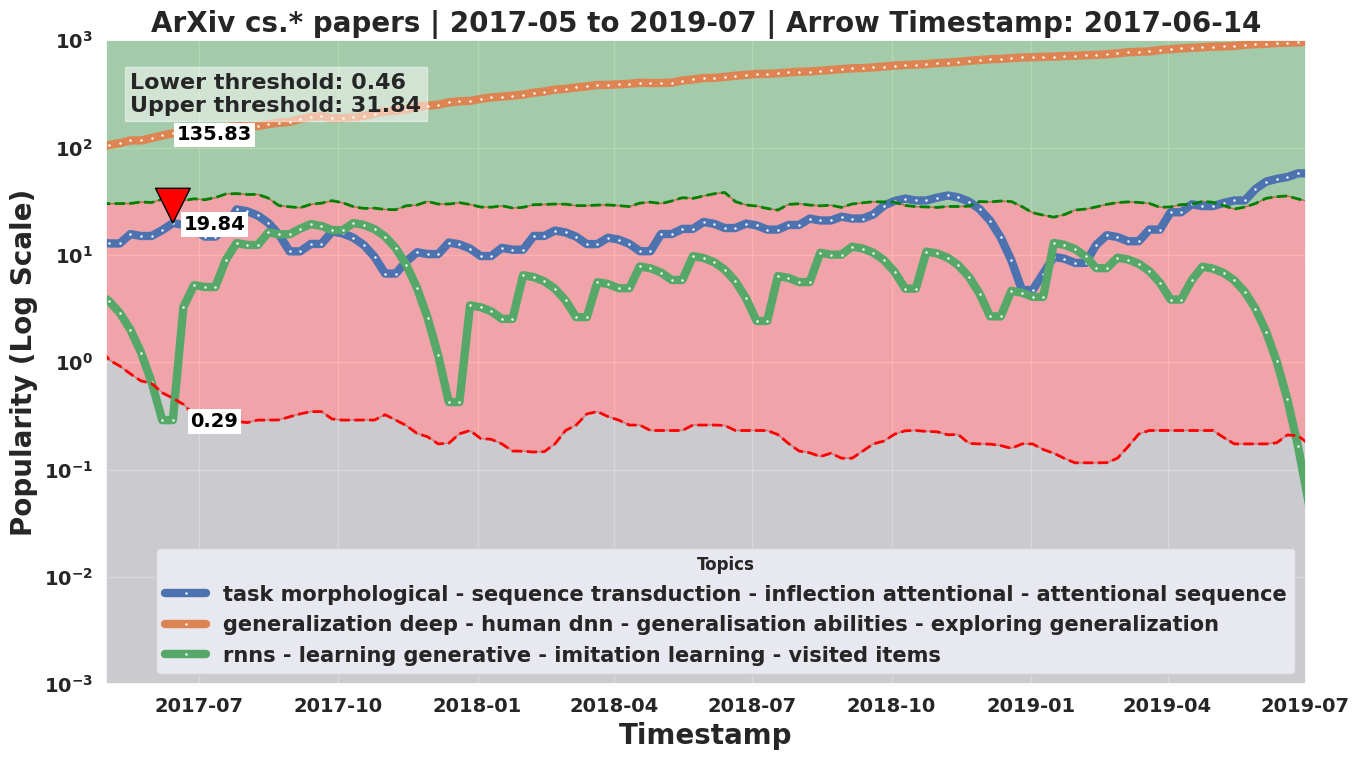

In [51]:
weak_signals = [476]
strong_signals = [83, 536]

topics_to_visualize = weak_signals + strong_signals
label_indices = {476: 14, 83: 20, 536: 14}  # Specify different label indices for each topic



start_date = datetime(2017, 5, 1)
end_date = datetime(2019, 7, 1)

arrow_topic = 476
arrow_scatter_index = 15

save_to_pdf=True
save_folder='Figures'

df = prepare_data(metadata, noise_df_list, ws_df_list, ss_df_list, topics_to_visualize, label_indices)
plot_topic_popularity(df, metadata, start_date, end_date, topics_to_visualize, arrow_topic, arrow_scatter_index, save_to_pdf, save_folder)

In [52]:
# Usage example
folder = "signal_evolution_data_arxiv_2/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)
print(len(metadata['timestamps']), metadata['timestamps'][0], metadata['timestamps'][-1])

253 2017-04-01 00:00:00 2022-01-29 00:00:00


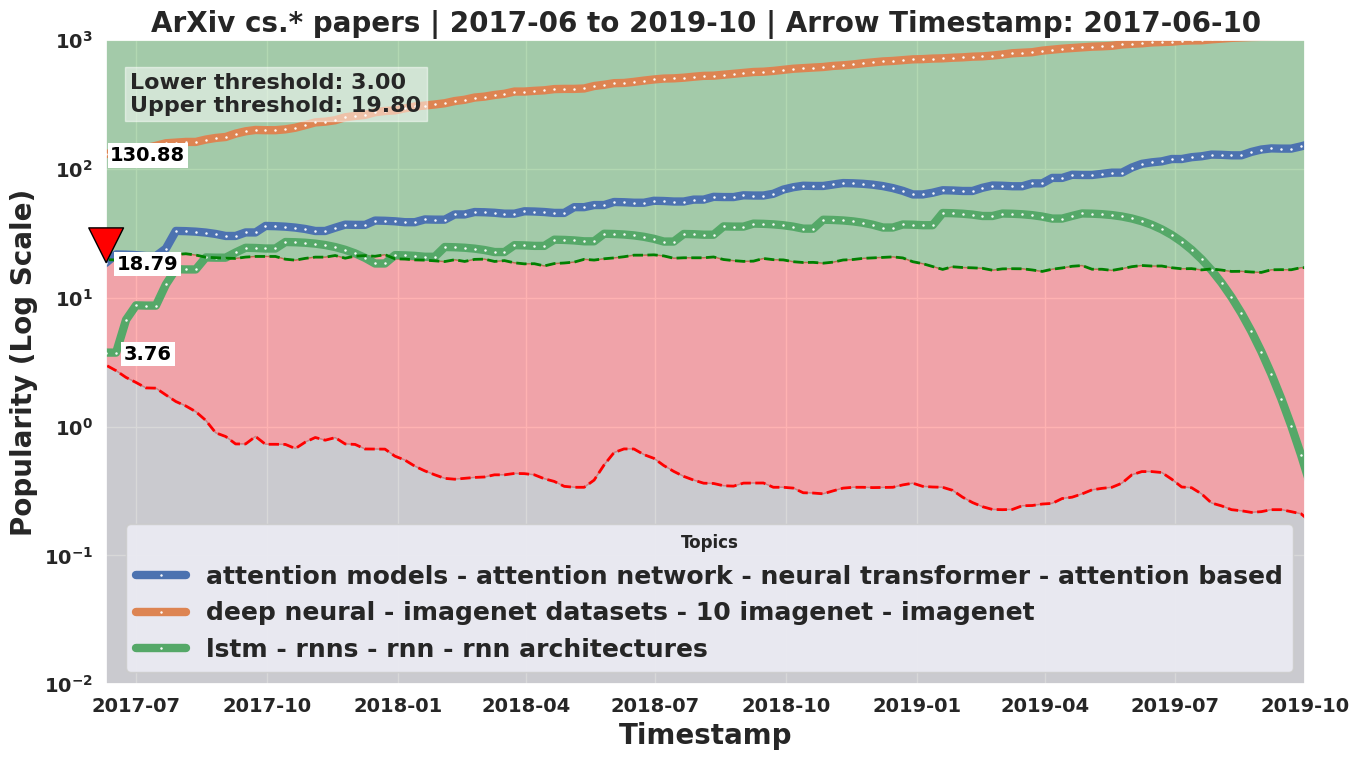

In [57]:
weak_signals = [476]
strong_signals = [83, 536]

topics_to_visualize = weak_signals + strong_signals
label_indices = {476: 57, 83: 57, 536: 0}  # Specify different label indices for each topic



start_date = datetime(2017, 6, 10)
end_date = datetime(2019, 10, 1)

arrow_topic = 476
arrow_scatter_index = 10

save_to_pdf=True
save_folder='Figures'

df = prepare_data(metadata, noise_df_list, ws_df_list, ss_df_list, topics_to_visualize, label_indices)
plot_topic_popularity(df, metadata, start_date, end_date, topics_to_visualize, arrow_topic, arrow_scatter_index, save_to_pdf, save_folder)

# ZEROSHOT NYT

In [135]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime

def load_data(folder):
    metadata = pd.read_pickle(folder + 'metadata.pkl')
    noise_df_list = pd.read_pickle(folder + 'noise_dfs_over_time.pkl')
    ws_df_list = pd.read_pickle(folder + 'weak_signal_dfs_over_time.pkl')
    ss_df_list = pd.read_pickle(folder + 'strong_signal_dfs_over_time.pkl')
    return metadata, noise_df_list, ws_df_list, ss_df_list

def get_topic_data(topic, noise_df_list, ws_df_list, ss_df_list):
    data = []
    for i in range(len(noise_df_list)):
        noise_df, ws_df, ss_df = noise_df_list[i], ws_df_list[i], ss_df_list[i]
        if not noise_df.empty and topic in noise_df['Topic'].values:
            row = noise_df[noise_df['Topic'] == topic].iloc[0]
            data.append({'Timestamp': row['Latest_Timestamp'], 'Popularity': row['Latest_Popularity'], 'Category': 'Noise'})
        elif not ws_df.empty and topic in ws_df['Topic'].values:
            row = ws_df[ws_df['Topic'] == topic].iloc[0]
            data.append({'Timestamp': row['Latest_Timestamp'], 'Popularity': row['Latest_Popularity'], 'Category': 'Weak Signal'})
        elif not ss_df.empty and topic in ss_df['Topic'].values:
            row = ss_df[ss_df['Topic'] == topic].iloc[0]
            data.append({'Timestamp': row['Latest_Timestamp'], 'Popularity': row['Latest_Popularity'], 'Category': 'Strong Signal'})
        else:
            data.append({'Timestamp': metadata['timestamps'][i], 'Popularity': None, 'Category': None})
    return pd.DataFrame(data)

def load_zeroshot_data(file_path):
    return pd.read_json(file_path)

def plot_topic_popularity(automatic_df, zeroshot_df, metadata, start_date, end_date, current_date, save_to_pdf=False, save_folder=''):
    plt.figure(figsize=(14, 8))
    
    # Adjusting font sizes
    plt.rc('font', size=20)  # General font size
    plt.rc('axes', titlesize=20)  # Axes title
    plt.rc('axes', labelsize=20)  # X and Y labels
    plt.rc('xtick', labelsize=14)  # X tick labels
    plt.rc('ytick', labelsize=14)  # Y tick labels

    # Create the plot
    ax = plt.gca()
    
    # Plot the automatic signal
    sns.lineplot(data=automatic_df, x='Timestamp', y='Popularity', label='BERTrend',
                 marker='o', markersize=13, linewidth=6, ax=ax)
    
    # Plot the zeroshot signal
    sns.lineplot(data=zeroshot_df, x='Timestamp', y='Document_Count', label='BERTrend w/ 0-shot',
                 marker='o', markersize=13, linewidth=6, ax=ax)
    
    # Convert metadata['timestamps'] to datetime objects
    metadata['timestamps'] = [ts.to_pydatetime() for ts in metadata['timestamps']]
    
    # Fill the areas with different colors
    ax.fill_between(metadata['timestamps'], metadata['q3_values'], 10**5, color='green', alpha=0.3)
    ax.fill_between(metadata['timestamps'], metadata['q1_values'], metadata['q3_values'], color='red', alpha=0.3)
    ax.fill_between(metadata['timestamps'], 0, metadata['q1_values'], color='grey', alpha=0.3)
    
    # Plot the thresholds without adding them to the legend
    ax.plot(metadata['timestamps'], metadata['q1_values'], linestyle='--', color='red', label='_nolegend_', linewidth=2)
    ax.plot(metadata['timestamps'], metadata['q3_values'], linestyle='--', color='green', label='_nolegend_', linewidth=2)
    
    # Get the index of the current timestamp
    current_timestamp_index = metadata['timestamps'].index(current_date)
    q1_value = metadata['q1_values'][current_timestamp_index]
    q3_value = metadata['q3_values'][current_timestamp_index]
    
    # Add the lower and upper threshold values at the top left
    ax.text(0.02, 0.95, f'Lower threshold: {q1_value:.2f}\nUpper threshold: {q3_value:.2f}\nCurrent timestamp: {current_date.strftime("%Y-%m-%d")}',
            transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add vertical line on January 18, 2020
    jan_18_2020 = pd.Timestamp('2020-01-18')
    ax.axvline(x=jan_18_2020, color='black', linestyle='--', linewidth=2)
    
    # Add blue arrow for the automatic signal (BERTrend 3724)
    if not automatic_df.empty:
        first_automatic_timestamp = automatic_df['Timestamp'].iloc[0]
        first_automatic_popularity = automatic_df[automatic_df['Timestamp'] == first_automatic_timestamp]['Popularity'].values[0]
        ax.annotate('', xy=(first_automatic_timestamp, first_automatic_popularity),
                    xytext=(first_automatic_timestamp, first_automatic_popularity * 1.2),
                    arrowprops=dict(facecolor='blue', edgecolor='black', width=5, headwidth=25, headlength=25))
        ax.text(first_automatic_timestamp, first_automatic_popularity, f'{first_automatic_popularity:.2f}',
                fontsize=14, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add red arrows for the zeroshot signal
    zeroshot_arrow_timestamps = [pd.Timestamp('2019-11-21'), pd.Timestamp('2019-12-13'), pd.Timestamp('2020-01-06')]
    for timestamp in zeroshot_arrow_timestamps:
        if timestamp in zeroshot_df['Timestamp'].values:
            zeroshot_popularity = zeroshot_df[zeroshot_df['Timestamp'] == timestamp]['Document_Count'].values[0]
            ax.annotate('', xy=(timestamp, zeroshot_popularity),
                        xytext=(timestamp, zeroshot_popularity * 1.4),  # Adjust the height of the arrow
                        arrowprops=dict(facecolor='red', edgecolor='black', width=5, headwidth=25, headlength=25))
            
            diff_days = (jan_18_2020 - timestamp).days
            if diff_days > 0:
                diff_text = f'{diff_days} Days Before'
            else:
                diff_text = f'{abs(diff_days)} Days After'
            
            ax.text(timestamp, zeroshot_popularity * 2.5,  # Adjust the height of the text
                    f'{zeroshot_popularity:.2f} | {diff_text}',
                    fontsize=16, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1))
    
    plt.title(f'NYT News - Coronavirus Signal | {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')
    
    # Set plot properties
    plt.yscale('log')
    plt.xlabel('Timestamp')
    plt.ylabel('Popularity (Log Scale)')
    plt.xlim(start_date, end_date)
    plt.ylim(10**-2, 10**3)
    
    # Main legend for topics
    topic_legend = plt.legend(title='Topics', loc='lower right', prop={'size': 18, 'weight': 'bold'})
    plt.gca().add_artist(topic_legend)
    
    # Custom legend for signals
    handles = [
        Patch(color='green', alpha=0.3, label='Strong Signals'),
        Patch(color='red', alpha=0.3, label='Weak Signals'),
        Patch(color='grey', alpha=0.3, label='Noise')
    ]
    plt.legend(handles=handles, loc='lower left', title='Signal Strength', prop={'size': 18, 'weight': 'bold'})
    
    plt.tight_layout()
    
    if save_to_pdf:
        if not save_folder.endswith('/'):
            save_folder += '/'
        plt.savefig(f'{save_folder}topic_popularity_{start_date.strftime("%Y-%m-%d")}_to_{end_date.strftime("%Y-%m-%d")}.pdf')
    
    plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


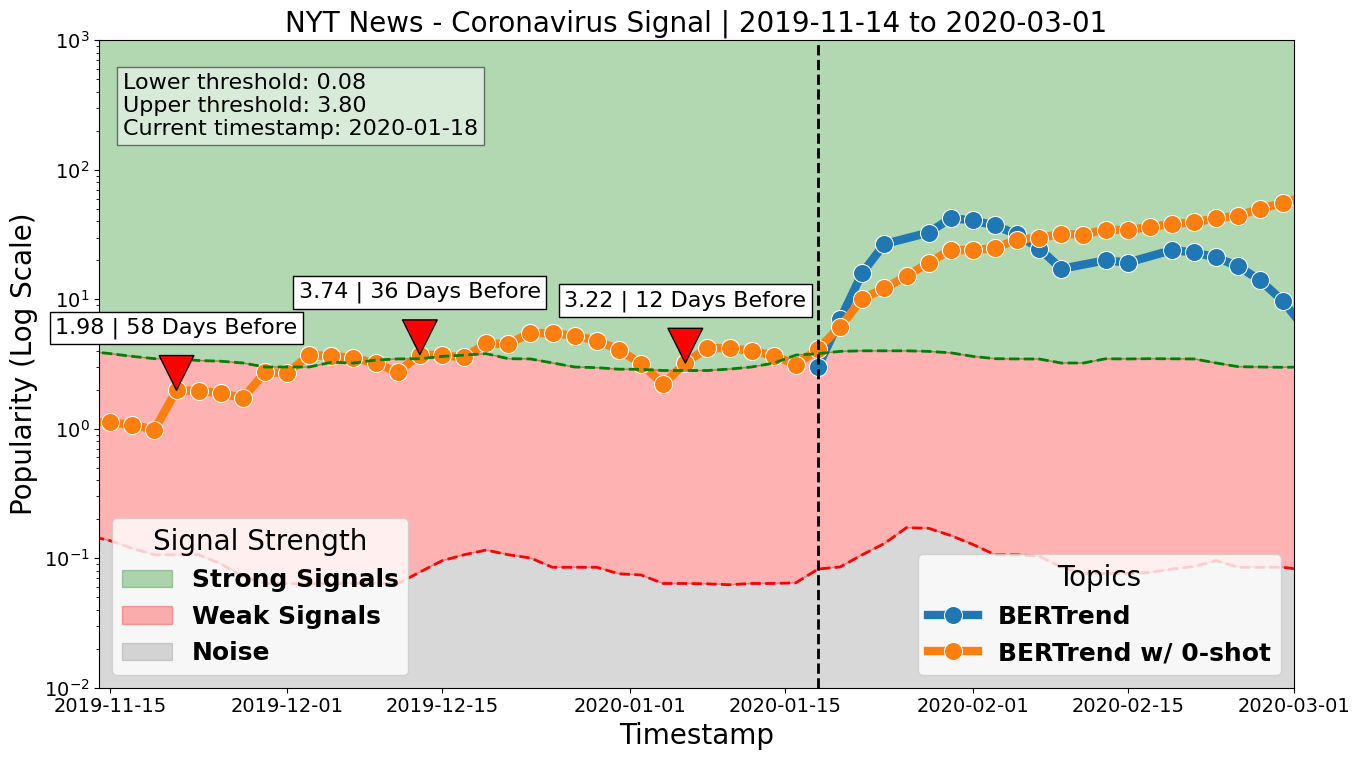

In [68]:
# Usage example
folder = "signal_evolution_data_nyt/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)

automatic_topic = 3724
automatic_df = get_topic_data(automatic_topic, noise_df_list, ws_df_list, ss_df_list)

zeroshot_file_path = "zeroshot_topics_data/zeroshot_topics_data.json"
zeroshot_df = load_zeroshot_data(zeroshot_file_path)

start_date = datetime(2019, 11, 14)
end_date = datetime(2020, 3, 1)

current_date = datetime(2020, 1, 18)


plot_topic_popularity(automatic_df, zeroshot_df, metadata, start_date, end_date, current_date, save_to_pdf=True, save_folder="Figures")

# NYT - TOPIC COUNT DESCRIPTION

In [58]:
import pandas as pd 

# Usage example
folder = "signal_evolution_data_nyt/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)

topic_signal_counts_path = folder + 'topic_signal_counts.json'
merge_df_counts_path = folder + 'topic_signal_counts_2.json'

df = pd.read_json(topic_signal_counts_path)
df = df.sort_values(by='timestamp', ascending=True)

df2 = pd.read_json(merge_df_counts_path)
df2 = df2.sort_values(by='timestamp', ascending=True)

# Define the granularity
granularity = timedelta(days=2)

# Increment each timestamp in df2 by the granularity
df2['timestamp'] = pd.to_datetime(df2['timestamp']) + granularity

# Sort df2 by timestamp after increment
df2 = df2.sort_values(by='timestamp', ascending=True)

# Prepare the new first row from df's first row, adjusting the timestamp with the same granularity
new_row = df.iloc[0].copy()  # Copy the first row from df
new_row['timestamp'] = pd.to_datetime(new_row['timestamp'])

# Append the new row to the top of df2
df2 = pd.concat([pd.DataFrame([new_row]), df2], ignore_index=True)

# Now, you might need to sort again if necessary
df2 = df2.sort_values(by='timestamp', ascending=True)

# Optionally, reset the index if you want clean indexing
df2.reset_index(drop=True, inplace=True)

In [59]:
print(metadata['timestamps'][0], metadata['timestamps'][-1])

2019-01-13 00:00:00 2022-12-31 00:00:00


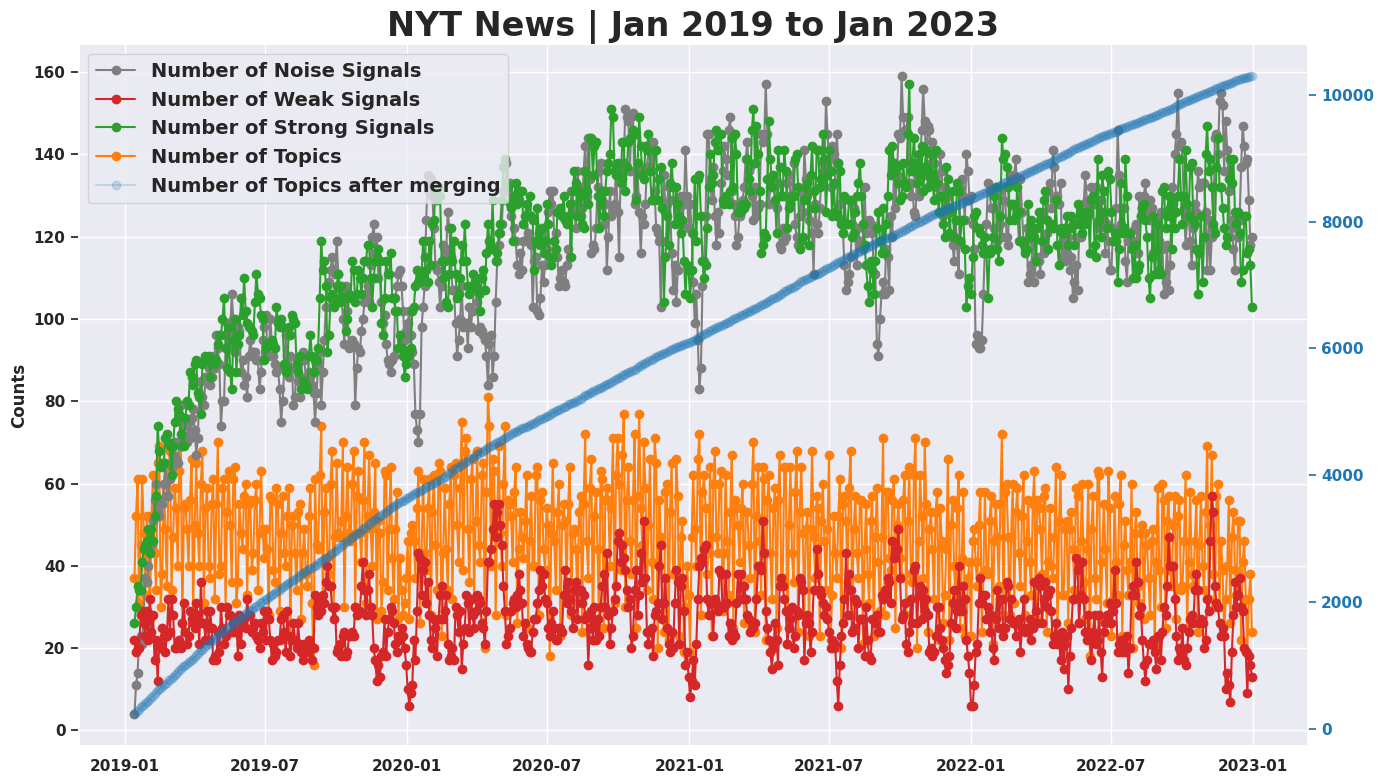

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

def create_timestamp_dict(metadata, noise_df_list, ws_df_list, ss_df_list, topic_signal_counts_path, merge_df_counts_path):
    topic_signal_counts_df = pd.read_json(topic_signal_counts_path)
    topic_signal_counts_df = topic_signal_counts_df.sort_values(by='timestamp', ascending=True)
    
    merge_df_counts = pd.read_json(merge_df_counts_path)
    merge_df_counts = merge_df_counts.sort_values(by='timestamp', ascending=True)
    
    timestamp_dict = {}
    
    for i, timestamp in enumerate(metadata['timestamps']):
        v1 = len(noise_df_list[i])
        v2 = len(ws_df_list[i])
        v3 = len(ss_df_list[i])
        v4 = topic_signal_counts_df[topic_signal_counts_df['timestamp'] == timestamp]['num_topics'].values[0]
        v5 = merge_df_counts[merge_df_counts['timestamp'] == timestamp]['num_topics'].values[0]
        
        timestamp_dict[timestamp] = (v1, v2, v3, v4, v5)
    
    return timestamp_dict

timestamp_dict = create_timestamp_dict(metadata, noise_df_list, ws_df_list, ss_df_list, topic_signal_counts_path, merge_df_counts_path)
plot_df = pd.DataFrame.from_dict(timestamp_dict, orient='index', columns=['num_noise', 'num_weak', 'num_strong', 'num_topics', 'num_merged_topics'])

plot_df['num_topics_smooth'] = plot_df['num_topics'].rolling(window=1, center=True).mean()
plot_df['num_noise_smooth'] = plot_df['num_noise'].rolling(window=1, center=True).mean()
plot_df['num_weak_smooth'] = plot_df['num_weak'].rolling(window=1, center=True).mean()
plot_df['num_strong_smooth'] = plot_df['num_strong'].rolling(window=1, center=True).mean()
plot_df['num_merged_topics_smooth'] = plot_df['num_merged_topics'].rolling(window=1, center=True).mean()

plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 22
legend_font = FontProperties(weight='bold', size=14)

sns.set(style="darkgrid")
palette = sns.color_palette("tab10")  # Generate a palette with Seaborn
plt.figure(figsize=(14, 8))

# Assigning colors from the Seaborn palette
line1, = plt.plot(plot_df.index, plot_df['num_topics_smooth'], marker='o', label='Number of Topics', color=palette[1])  # Orange
line2, = plt.plot(plot_df.index, plot_df['num_noise_smooth'], marker='o', label='Number of Noise Signals', color=palette[7])  # Grey
line3, = plt.plot(plot_df.index, plot_df['num_weak_smooth'], marker='o', label='Number of Weak Signals', color=palette[3])  # Red
line4, = plt.plot(plot_df.index, plot_df['num_strong_smooth'], marker='o', label='Number of Strong Signals', color=palette[2])  # Green
plt.ylabel('Counts', fontweight='bold')

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

ax2 = plt.gca().twinx()
line5, = ax2.plot(plot_df.index, plot_df['num_merged_topics_smooth'], marker='o', label='Total Number of Topics after merging', color=palette[0], alpha=0.2)  # Blue
ax2.set_ylabel('', color=palette[0], fontweight='bold')
ax2.tick_params(axis='y', colors=palette[0])
ax2.grid(False)

plt.xlabel('Timestamp', fontweight='bold')
plt.title('NYT News | Jan 2019 to Jan 2023', fontsize=24, fontweight="bold")
handles = [line2, line3, line4, line1, line5]
labels = ['Number of Noise Signals', 'Number of Weak Signals', 'Number of Strong Signals', 'Number of Topics', 'Number of Topics after merging']
plt.legend(handles, labels, loc='upper left', prop=legend_font)

plt.yticks(fontweight='bold')

plt.tight_layout()
plt.savefig('Figures/NYT.pdf')

plt.show()



# ARXIV - TOPIC COUNT DESCRIPTION

In [139]:
import pandas as pd 

# Usage example
folder = "signal_evolution_data_arxiv/"
metadata, noise_df_list, ws_df_list, ss_df_list = load_data(folder)

topic_signal_counts_path = folder + 'topic_signal_counts.json'
merge_df_counts_path = folder + 'topic_signal_counts_2.json'

df = pd.read_json(topic_signal_counts_path)
df = df.sort_values(by='timestamp', ascending=True)

df2 = pd.read_json(merge_df_counts_path)
df2 = df2.sort_values(by='timestamp', ascending=True)

# Define the granularity
granularity = timedelta(days=7)

# Increment each timestamp in df2 by the granularity
df2['timestamp'] = pd.to_datetime(df2['timestamp']) + granularity

# Sort df2 by timestamp after increment
df2 = df2.sort_values(by='timestamp', ascending=True)

# Prepare the new first row from df's first row, adjusting the timestamp with the same granularity
new_row = df.iloc[0].copy()  # Copy the first row from df
new_row['timestamp'] = pd.to_datetime(new_row['timestamp'])

# Append the new row to the top of df2
df2 = pd.concat([pd.DataFrame([new_row]), df2], ignore_index=True)

# Now, you might need to sort again if necessary
df2 = df2.sort_values(by='timestamp', ascending=True)

# Optionally, reset the index if you want clean indexing
df2.reset_index(drop=True, inplace=True)

In [140]:
df.tail()

,timestamp,num_topics
332,2023-11-29,552
302,2023-12-06,553
196,2023-12-13,548
306,2023-12-20,397
290,2023-12-27,108


In [141]:
df2.tail()

,timestamp,num_topics
360,2023-11-29,3762
361,2023-12-06,3771
362,2023-12-13,3776
363,2023-12-20,3779
364,2023-12-27,3781


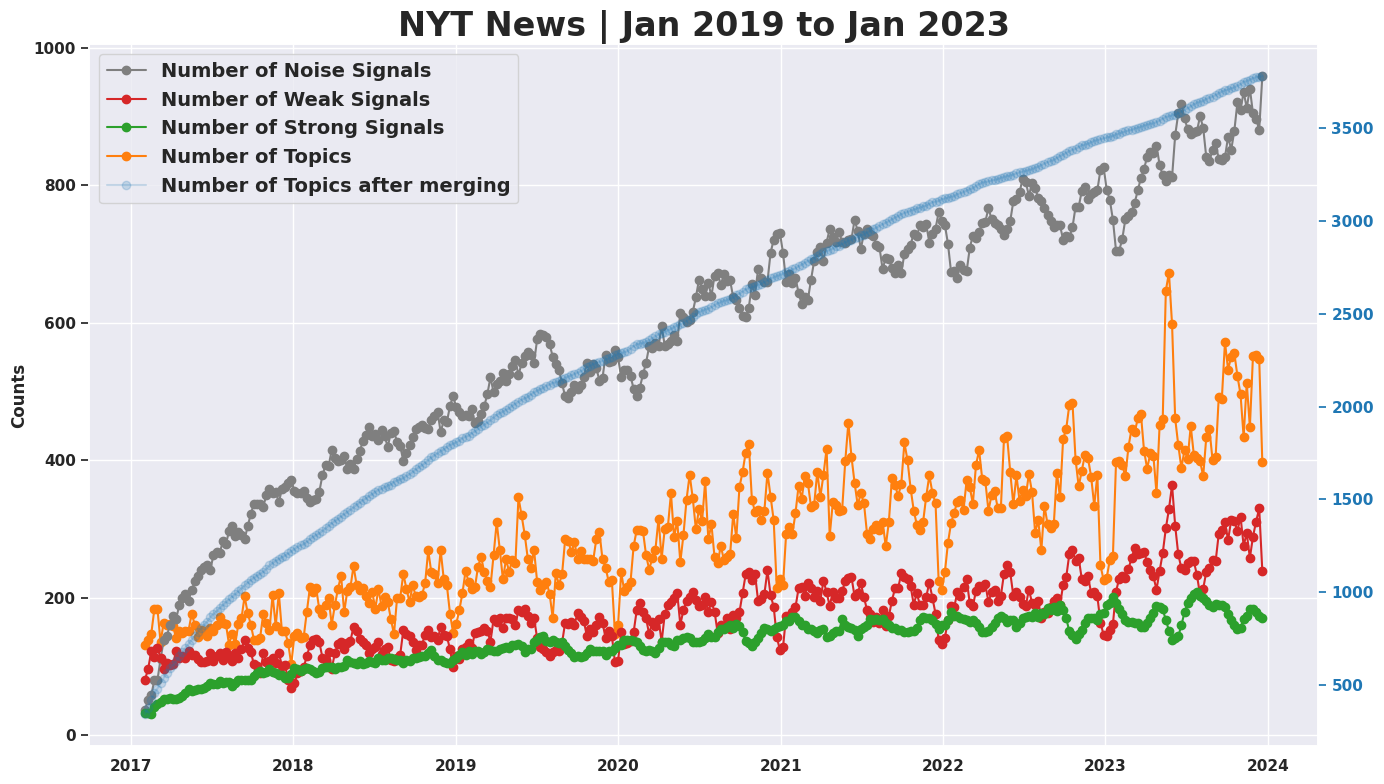

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

def create_timestamp_dict(metadata, noise_df_list, ws_df_list, ss_df_list, topic_signal_counts_path, merge_df_counts_path):
    topic_signal_counts_df = pd.read_json(topic_signal_counts_path)
    topic_signal_counts_df = topic_signal_counts_df.sort_values(by='timestamp', ascending=True)
    
    merge_df_counts = pd.read_json(merge_df_counts_path)
    merge_df_counts = merge_df_counts.sort_values(by='timestamp', ascending=True)
    
    timestamp_dict = {}
    
    for i, timestamp in enumerate(metadata['timestamps']):
        v1 = len(noise_df_list[i])
        v2 = len(ws_df_list[i])
        v3 = len(ss_df_list[i])
        v4 = topic_signal_counts_df[topic_signal_counts_df['timestamp'] == timestamp]['num_topics'].values[0]
        v5 = merge_df_counts[merge_df_counts['timestamp'] == timestamp]['num_topics'].values[0]
        
        timestamp_dict[timestamp] = (v1, v2, v3, v4, v5)
    
    return timestamp_dict

timestamp_dict = create_timestamp_dict(metadata, noise_df_list, ws_df_list, ss_df_list, topic_signal_counts_path, merge_df_counts_path)
plot_df = pd.DataFrame.from_dict(timestamp_dict, orient='index', columns=['num_noise', 'num_weak', 'num_strong', 'num_topics', 'num_merged_topics'])

plot_df['num_topics_smooth'] = plot_df['num_topics'].rolling(window=1, center=True).mean()
plot_df['num_noise_smooth'] = plot_df['num_noise'].rolling(window=1, center=True).mean()
plot_df['num_weak_smooth'] = plot_df['num_weak'].rolling(window=1, center=True).mean()
plot_df['num_strong_smooth'] = plot_df['num_strong'].rolling(window=1, center=True).mean()
plot_df['num_merged_topics_smooth'] = plot_df['num_merged_topics'].rolling(window=1, center=True).mean()

plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 22
legend_font = FontProperties(weight='bold', size=14)

sns.set(style="darkgrid")
palette = sns.color_palette("tab10")  # Generate a palette with Seaborn
plt.figure(figsize=(14, 8))

# Assigning colors from the Seaborn palette
line1, = plt.plot(plot_df.index, plot_df['num_topics_smooth'], marker='o', label='Number of Topics', color=palette[1])  # Orange
line2, = plt.plot(plot_df.index, plot_df['num_noise_smooth'], marker='o', label='Number of Noise Signals', color=palette[7])  # Grey
line3, = plt.plot(plot_df.index, plot_df['num_weak_smooth'], marker='o', label='Number of Weak Signals', color=palette[3])  # Red
line4, = plt.plot(plot_df.index, plot_df['num_strong_smooth'], marker='o', label='Number of Strong Signals', color=palette[2])  # Green
plt.ylabel('Counts', fontweight='bold')

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

ax2 = plt.gca().twinx()
line5, = ax2.plot(plot_df.index, plot_df['num_merged_topics_smooth'], marker='o', label='Total Number of Topics after merging', color=palette[0], alpha=0.2)  # Blue
ax2.set_ylabel('', color=palette[0], fontweight='bold')
ax2.tick_params(axis='y', colors=palette[0])
ax2.grid(False)

plt.xlabel('Timestamp', fontweight='bold')
plt.title('NYT News | Jan 2019 to Jan 2023', fontsize=24, fontweight="bold")
handles = [line2, line3, line4, line1, line5]
labels = ['Number of Noise Signals', 'Number of Weak Signals', 'Number of Strong Signals', 'Number of Topics', 'Number of Topics after merging']
plt.legend(handles, labels, loc='upper left', prop=legend_font)

plt.yticks(fontweight='bold')

plt.tight_layout()
plt.savefig('Figures/ARXIV.pdf')

plt.show()

